## Calculating Distance Using the Haversine Formula

In [4]:
import pandas as pd

# Load the dataset
file_path = 'Datasets/Final_cleaned_dataset/mad_final_cleaned_date.csv'
df_mad = pd.read_csv(file_path, delimiter = ';')

# Display the first few rows and theolumn names
df_mad.head(), df_mad.columns


(  neighbourhood_group_cleansed                   id  \
 0                       Retiro  1104967621421098322   
 1           Puente de Vallecas   930941073152690361   
 2           Puente de Vallecas             51647382   
 3                  Carabanchel  1026072412626070839   
 4                    Salamanca   766423030884644417   
 
                                         listing_url  \
 0  https://www.airbnb.com/rooms/1104967621421098322   
 1   https://www.airbnb.com/rooms/930941073152690361   
 2             https://www.airbnb.com/rooms/51647382   
 3  https://www.airbnb.com/rooms/1026072412626070839   
 4   https://www.airbnb.com/rooms/766423030884644417   
 
                                name    host_id        host_name  \
 0  Habitación de lujo; baño privado  565307927         Carolina   
 1            habitación para pareja  442944608   Jonathan Jesus   
 2            Buenos Aires en Madrid  252336445            Norma   
 3            Habitación Madrid Rio!  545435841     

In [12]:
df_mad["price"].sort_values()

1502        8.0
3046        8.0
264         9.0
5336        9.0
9784       10.0
          ...  
7646     9059.0
17552    9059.0
2657     9218.0
856      9999.0
19540    9999.0
Name: price, Length: 26867, dtype: float64

In [11]:
# Dropping rows where the price is exactly 21000 (the max as it seems strange)
df_mad.drop(df_mad.loc[df_mad["price"] == 21000].index, inplace=True)

In [17]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Coordinates of Plaza Catalunya, Barcelona
city_center_mad = (40.416729, -3.703339)

# Apply the Haversine function
df_mad['distance_from_city_center'] = df_mad.apply(
    lambda row: haversine(row['longitude'], row['latitude'], city_center_mad[1], city_center_mad[0]), axis=1
)


In [18]:
df_mad.head(1)

,neighbourhood_group_cleansed,id,listing_url,name,host_id,host_name,calculated_host_listings_count,host_is_superhost,latitude,longitude,...,elevator,air conditioning,long_term,short_term,possible_long_term,number_of_reviews,review_scores_rating,room_type_encoded,bedrooms_encoded,distance_from_city_center
0,Retiro,1104967621421098322,https://www.airbnb.com/rooms/1104967621421098322,Habitación de lujo; baño privado,565307927,Carolina,1,f,40.40698,-3.675015,...,0,0,0,1,0,2,4.5,1,0,2.631659


#### Check Data for Outliers or Errors
Sometimes, input data errors (like incorrect sign or misplaced decimal points in latitude or longitude) can cause calculation errors:

In [19]:
# Check min and max values to spot obvious errors
print(df_mad['latitude'].min(), df_mad['latitude'].max())
print(df_mad['longitude'].min(), df_mad['longitude'].max())

40.33139673018308 40.53553
-3.8330714277148017 -3.5459040932605648


#### Validate Coordinates
Make sure that the coordinates used for the city center and each Airbnb listing are correct and consistent in terms of formatting and precision:

In [20]:
# Ensure there are no negative or unrealistic coordinates in your data
df_mad[['latitude', 'longitude']].describe()


,latitude,longitude
count,26867.000000,26867.000000
mean,40.421638,-3.694069
std,0.023544,0.027789
min,40.331397,-3.833071
25%,40.409350,-3.707540
50%,40.420310,-3.701083
75%,40.431806,-3.685505
max,40.535530,-3.545904


In [21]:
df_mad['distance_from_city_center'].sort_values()

9601      0.000938
17707     0.004687
15436     0.012822
22444     0.015201
18437     0.018516
           ...    
3508     13.038378
7179     13.210091
10440    13.329207
11223    13.448495
4938     14.521432
Name: distance_from_city_center, Length: 26867, dtype: float64

In [24]:
# Categorize distances
# Calculate the minimum and maximum distance to define bins dynamically
min_distance = df_mad['distance_from_city_center'].min()
max_distance = df_mad['distance_from_city_center'].max()

min_distance, max_distance

(0.000937854784577459, 14.52143243844296)

In [27]:
# Define bins to match the desired categories, ensuring that all data is included
bins = [min_distance - 0.0001, 1, 2, 3, 5, 10, max_distance + 0.1]
labels = ['<1 km', '1-2 km', '2-3 km', '3-5 km', '5-10 km', '>10 km']

# Categorize distances using pd.cut
df_mad['distance_category'] = pd.cut(df_mad['distance_from_city_center'], bins=bins, labels=labels, include_lowest=True)

# Check the distribution of the distance categories
print(df_mad['distance_category'].value_counts())

# Display some rows to verify categorization
df_mad[['distance_from_city_center', 'distance_category']].head()

distance_category
<1 km      9123
3-5 km     5162
1-2 km     4595
5-10 km    4052
2-3 km     3504
>10 km      431
Name: count, dtype: int64


,distance_from_city_center,distance_category
0,2.631659,2-3 km
1,3.931242,3-5 km
2,3.616424,3-5 km
3,2.602584,2-3 km
4,3.052941,3-5 km


In [28]:
from sklearn.preprocessing import StandardScaler

# Normalize 'price' and 'distance_from_city_center'
scaler = StandardScaler()
df_mad[['price_normalized', 'distance_from_city_center_normalized']] = scaler.fit_transform(df_mad[['price', 'distance_from_city_center']])


/var/folders/t3/2pbngt7x2rxdwml4ql51pbt80000gn/T/ipykernel_31594/3554239528.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_mad.groupby(['neighbourhood_group_cleansed', 'distance_category']).agg({


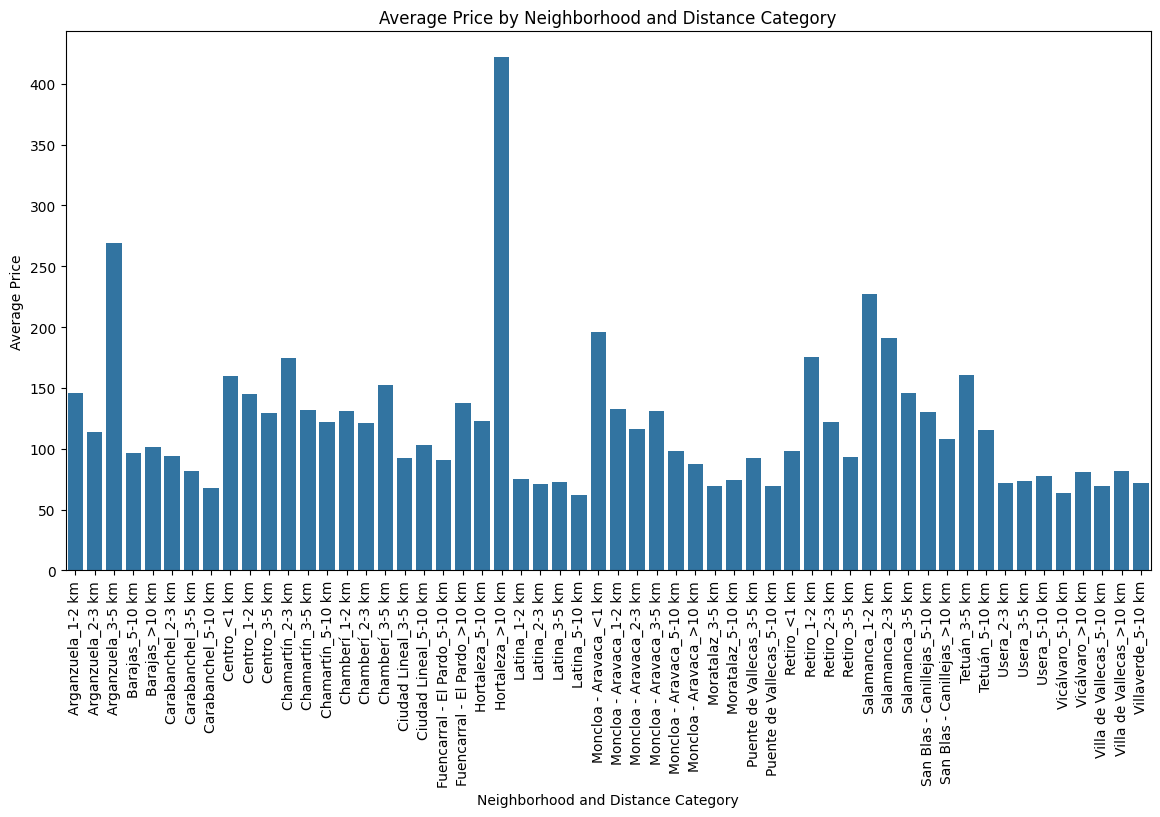

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create an interaction term
# Ensure both columns are of type string before concatenation
df_mad['neighborhood_distance_interaction'] = df_mad['neighbourhood_group_cleansed'].astype(str) + '_' + df_mad['distance_category'].astype(str)

# Grouped analysis
grouped_data = df_mad.groupby(['neighbourhood_group_cleansed', 'distance_category']).agg({
    'price': ['mean', 'median', 'count'],
    'review_scores_rating': ['mean', 'std']
}).reset_index()

# Sort the grouped_data by neighborhood and distance category
grouped_data = grouped_data.sort_values(by=['neighbourhood_group_cleansed', 'distance_category'])

# Create the interaction term for plotting purposes
grouped_data['neighborhood_distance_interaction'] = grouped_data['neighbourhood_group_cleansed'].astype(str) + '_' + grouped_data['distance_category'].astype(str)

# Filter out rows where the mean price is NaN or zero
grouped_data_filtered = grouped_data[grouped_data[('price', 'mean')].notna() & (grouped_data[('price', 'mean')] > 0)]

# Visualization with filtered data
plt.figure(figsize=(14, 7))
sns.barplot(x='neighborhood_distance_interaction', y=('price', 'mean'), data=grouped_data_filtered)
plt.title('Average Price by Neighborhood and Distance Category')
plt.xlabel('Neighborhood and Distance Category')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

## Price Categorization Using Percentiles

In [30]:
# Calculate percentiles
low_cost_threshold = df_mad['price_normalized'].quantile(0.33)  # Change quantile values as per requirement
economic_threshold = df_mad['price_normalized'].quantile(0.66)

# Categorize price_normalized
#s into 'Luxury', 'Economic', and 'Low-Cost'
df_mad['price_category'] = pd.cut(df_mad['price_normalized'], bins=[df_mad['price_normalized'].min(), low_cost_threshold, economic_threshold, df_mad['price_normalized'].max()],
                              labels=['Low-Cost', 'Economic', 'Luxury'], include_lowest=True)

# Display the distribution of price_normalized
# categories
print(df_mad['price_category'].value_counts())

# Optionally, view some rows to confirm the categorization
print(df_mad[['price_normalized', 'price_category']].head())


price_category
Economic    9013
Luxury      8979
Low-Cost    8875
Name: count, dtype: int64
   price_normalized price_category
0         -0.287895       Low-Cost
1         -0.507759       Low-Cost
2         -0.469706       Low-Cost
3         -0.465478       Low-Cost
4         -0.152594       Economic


#### - Percentiles: The quantile function is used to determine the thresholds for each category. In this example, 33% of listings fall into 'Low-Cost', the next 33% into 'Economic', and the remaining 34% into 'Luxury'.
#### - Categorization: pd.cut is used to segment the price into categories based on these thresholds. The bins parameter specifies the edges of the bins, and labels assigns names to these bins.
#### - Visualization: The code prints the count of listings in each category to help you verify the distribution.

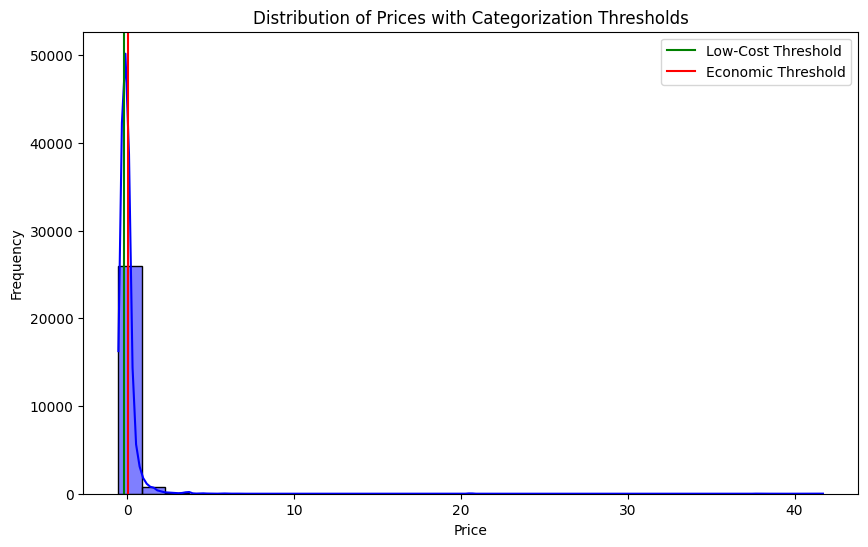

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(df_mad['price_normalized'], bins=30, kde=True, color='blue')
plt.axvline(x=low_cost_threshold, color='green', label='Low-Cost Threshold')
plt.axvline(x=economic_threshold, color='red', label='Economic Threshold')
plt.title('Distribution of Prices with Categorization Thresholds')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## The visual is not very representative - due to a large number of observations fall into a small price range, and a few outliers extend the scale of the plot. 


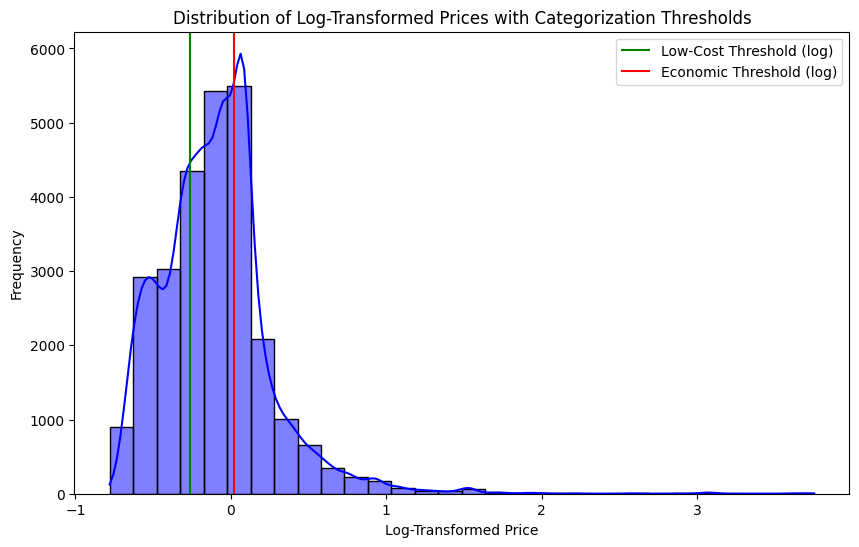

In [32]:
import numpy as np

# Assuming 'df_mad' is your DataFrame and 'price_normalized' is the column you are analyzing
df_mad['log_price'] = np.log1p(df_mad['price_normalized'])  # Apply log transformation to price_normalized

# Plotting the histogram with log prices
plt.figure(figsize=(10, 6))
sns.histplot(df_mad['log_price'], bins=30, kde=True, color='blue')

# Calculate new thresholds on log-transformed prices
log_low_cost_threshold = np.log1p(df_mad['price_normalized']).quantile(0.33)
log_economic_threshold = np.log1p(df_mad['price_normalized']).quantile(0.66)

# Adding vertical lines for new thresholds
plt.axvline(x=log_low_cost_threshold, color='green', label='Low-Cost Threshold (log)')
plt.axvline(x=log_economic_threshold, color='red', label='Economic Threshold (log)')

plt.title('Distribution of Log-Transformed Prices with Categorization Thresholds')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Observations:

#### 1. Data Distribution:
The data is log-transformed, which helps to normalize the distribution of prices.
The distribution shows a peak (mode) just below 0 on the log scale, indicating that the majority of listings have prices that are slightly below the median of the distribution before transformation.

#### 2. Threshold Placement:
Low-Cost Threshold (green line): This threshold is located just below the mode, indicating that a significant portion of the listings are classified as low-cost. The area to the left of this line includes all the low-cost listings.
Economic Threshold (red line): This threshold is just to the right of the mode, indicating that a substantial number of listings fall within the economic category. Listings in this category represent the higher end of the common price range.
The sharp drop-off after the economic threshold suggests that fewer listings are priced in the higher range, which might correspond to the 'Luxury' category.

#### 3. Skewness:
Even after log transformation, the distribution is slightly right-skewed. This skewness indicates that there are still some higher-priced listings, though they are relatively fewer.

#### 4. Price Segmentation:
The plot illustrates that the majority of listings are either low-cost or economic, with very few listings falling into what might be considered a luxury category (to the right of the economic threshold).
This segmentation could imply that the market is primarily focused on affordable options, with a smaller market segment for higher-end listings.

#### 5. Implications for Analysis:
Marketing and Strategy: The majority of listings being concentrated around the low-cost and economic thresholds suggests that marketing efforts could be tailored to these segments, possibly focusing on the value proposition in these ranges.
Further Investigation: The skewness and the relative scarcity of listings above the economic threshold might warrant further investigation, such as examining what differentiates the few luxury listings from the bulk of the market.

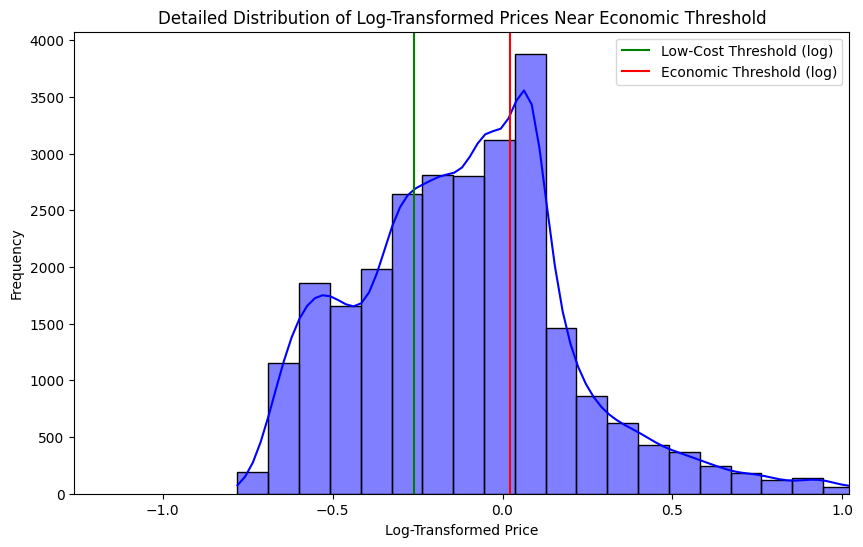

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focusing on the dense region near the economic threshold
plt.figure(figsize=(10, 6))
sns.histplot(df_mad['log_price'], bins=50, kde=True, color='blue')
plt.axvline(x=log_low_cost_threshold, color='green', label='Low-Cost Threshold (log)')
plt.axvline(x=log_economic_threshold, color='red', label='Economic Threshold (log)')

# Zooming into the region of interest
plt.xlim([log_low_cost_threshold - 1, log_economic_threshold + 1])  # Adjust the limits as needed to focus on the region of interest

plt.title('Detailed Distribution of Log-Transformed Prices Near Economic Threshold')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [37]:
# Collect necessary columns and export into a new csv file
feature_data_mad = df_mad[df_mad['long_term'] != 1][["id", "neighbourhood_group_cleansed", "name", "host_id", "host_name", "host_is_superhost", 
                                  "calculated_host_listings_count", "latitude", "longitude", "kitchen", 
                                 "patio or balcony", "elevator", "air conditioning", "number_of_reviews", "review_scores_rating", "room_type_encoded",
                                   "bedrooms_encoded", "price", "price_category", "distance_from_city_center", "distance_category"]]
# Save to CSV or another format for use in visualization tools
feature_data_mad.to_csv("Datasets/Final_cleaned_dataset/labled_features_mad.csv", index=False)

In [36]:
feature_data_mad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26215 entries, 0 to 26867
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   neighbourhood_group_cleansed  26215 non-null  object  
 1   host_is_superhost             26215 non-null  object  
 2   latitude                      26215 non-null  float64 
 3   longitude                     26215 non-null  float64 
 4   kitchen                       26215 non-null  int64   
 5   patio or balcony              26215 non-null  int64   
 6   elevator                      26215 non-null  int64   
 7   air conditioning              26215 non-null  int64   
 8   review_scores_rating          26215 non-null  float64 
 9   room_type_encoded             26215 non-null  int64   
 10  bedrooms_encoded              26215 non-null  int64   
 11  price                         26215 non-null  float64 
 12  price_category                26215 non-null  categ